In [1]:
import os
from collections import defaultdict
import compress_pickle
import numpy as np
import ipywidgets as widgets
import networkx as nx
import matplotlib.pyplot as plt
import logging

from pybkb.bkb import BKB
from pybkb.utils.cytoscape import render
from pybkb.learn import BKBLearner, BNLearner
from pybkb.utils.mp import MPLogger

%matplotlib inline


In [2]:
with open('../data/keel/post-operative-standard_classification-no_missing_values.dat', 'rb') as data_file:
    data, feature_states, srcs = compress_pickle.load(data_file, 'lz4')

In [3]:
data.shape

(87, 26)

In [3]:
def construct_rv_dataset(data, feature_states):
    features = list(set([f for f, _ in feature_states]))
    features_dict = defaultdict(list)
    for f, s in feature_states:
        features_dict[f].append(s)
    feature_dict = dict(features_dict)
    rv_data = []
    for row in data:
        f_dict = {feature_states[i][0]: feature_states[i][1] for i in np.where(row == 1)[0]}
        new_row = []
        for feature in features:
            new_row.append(feature_dict[feature].index(f_dict[feature]))
        rv_data.append(new_row)
    return np.array(rv_data), features, features_dict
        

In [17]:
bn_learner = BNLearner(backend='gobnilp', score='mdl_ent', palim=8)

In [5]:
bn_learner.fit(data, feature_states, verbose=True)

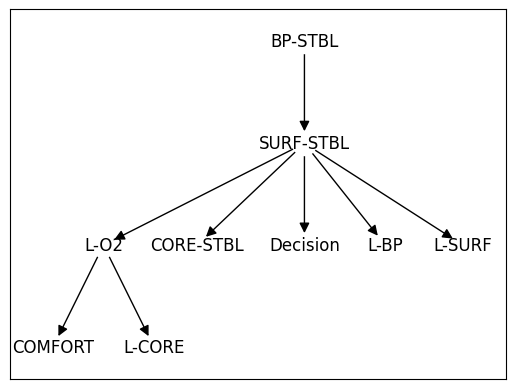

In [6]:
bn_learner.m.learned_bn.plot(abbrev=False)

In [4]:
bkb_learner = BKBLearner(backend='gobnilp', score='mdl_ent', distributed=False, palim=2)

In [5]:
bkb_learner.fit(data, feature_states, srcs=srcs, collapse=True)

Learning Fragments:   0%|                                                                                                            | 0/87 [00:36<?, ?it/s]


GurobiError: Failed to connect to token server 'rmv.thayer.dartmouth.edu' (port 41954) - license file '/home/chase/gurobi.lic'.  Consult the Quick Start Guide for instructions on starting a token server.

In [8]:
perc_threshold = 0
count_min = np.round((perc_threshold/100)*data.shape[0])
bkb_learner.learned_bkb.render_nx(only_rvs=True, show_num_edges=False,layout_name='circle', edge_weight_multiplier=.15, count_min=count_min)

CytoscapeWidget(cytoscape_layout={'name': 'circle', 'nodeSpacing': 10, 'edgeLengthVal': 10}, cytoscape_style=[…

In [10]:
rv_data, features, features_dict = construct_rv_dataset(data, feature_states)

In [50]:
features

['COMFORT',
 'SURF-STBL',
 'L-CORE',
 'L-O2',
 'CORE-STBL',
 'Decision',
 'L-BP',
 'BP-STBL',
 'L-SURF']

  0%|          | 0/9 [00:00<?, ?it/s]

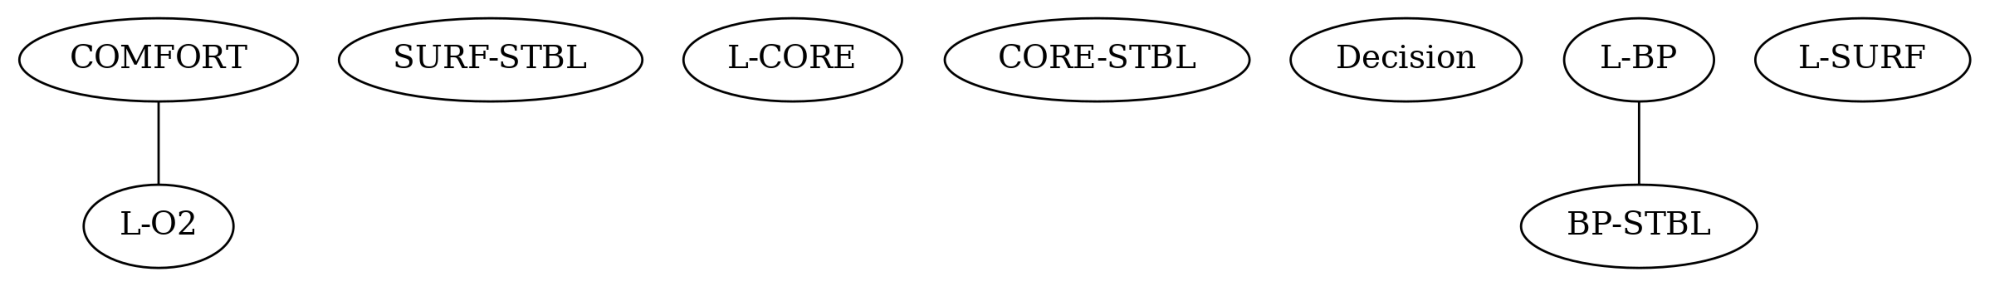

In [11]:
from causallearn.search.ConstraintBased.PC import pc
cg = pc(rv_data, indep_test='fisherz')
cg.draw_pydot_graph(labels=features)

In [12]:
from causallearn.search.ScoreBased.ExactSearch import bic_exact_search
dag_est, search_stats = bic_exact_search(rv_data)
dag_est

array([[0., 0., 1., 1., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])


GRaSP completed in: 0.01s 


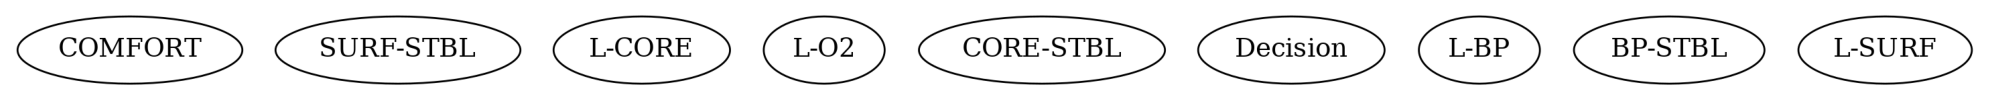

In [13]:
from causallearn.search.PermutationBased.GRaSP import grasp
G = grasp(rv_data)
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io
pyd = GraphUtils.to_pydot(G, labels=features)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

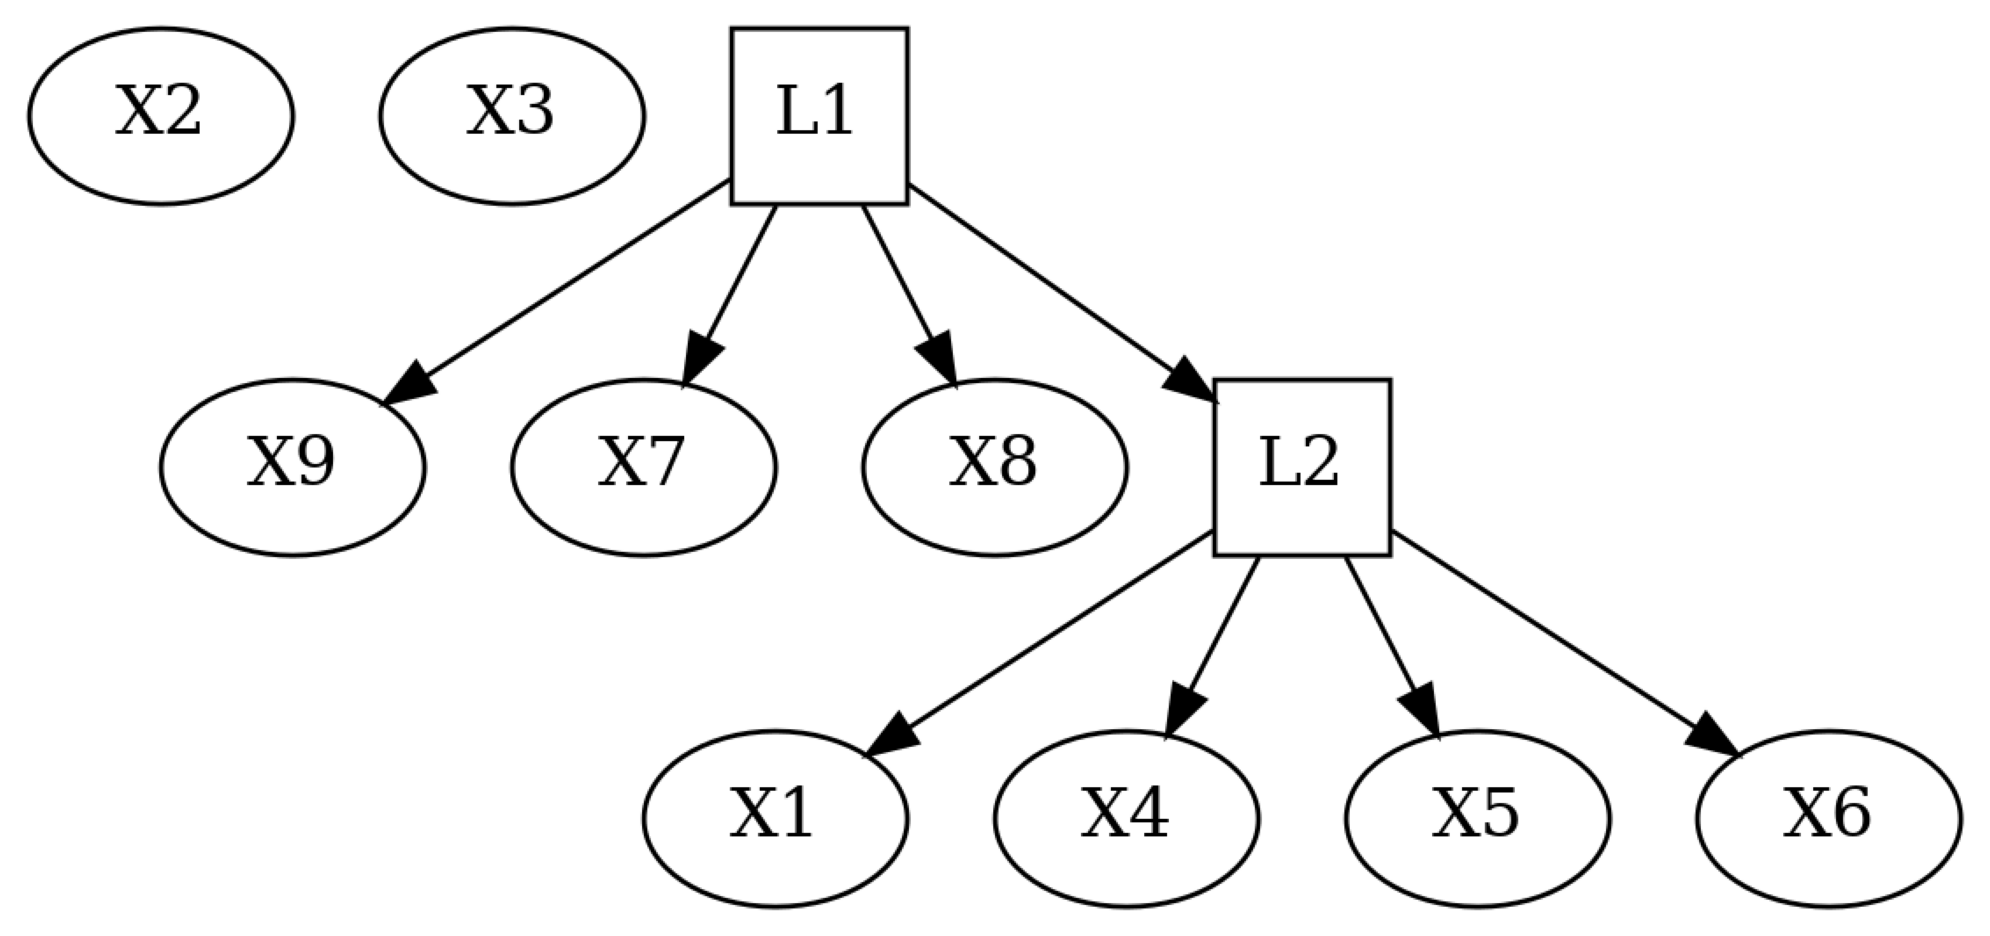

In [14]:
from causallearn.search.HiddenCausal.GIN.GIN import GIN
G, K = GIN(rv_data)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(G)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

In [15]:
from causallearn.search.FCMBased import lingam
model = lingam.ICALiNGAM()
model.fit(rv_data)

print(model.causal_order_)
print(model.adjacency_matrix_)

[0, 1, 3, 4, 5, 6, 7, 2, 8]
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.25110274 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]


backward


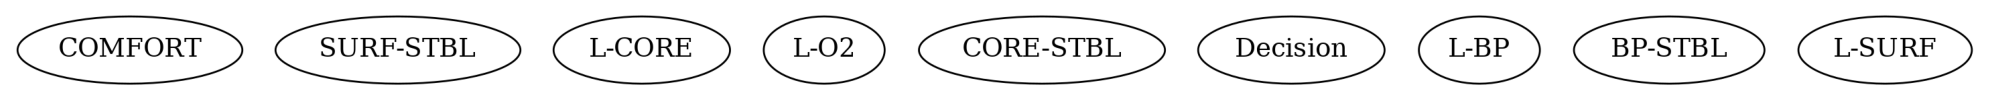

In [16]:
from causallearn.search.ScoreBased.GES import ges

# default parameters
Record = ges(rv_data)


# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(Record['G'], labels=features)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

In [168]:
# Reasoning
import itertools
from pybkb.reason.bkb import BKBReasoner
from pybkb.reason.bn import BNReasoner

all_features = []
all_states = []
for f, states in features_dict.items():
    all_features.append(f)
    all_states.append(states)
    
#bkb_reasoner = BKBReasoner(bkb_learner.learned_bkb)
structure = []

for rv in features:
    pa = bn_learner.bn.get_parents(rv)
    print(pa)
    if not pa:
        structure.append(())
        continue
    structure.append(tuple([features.index(_pa) for _pa in pa]))
print(structure)
print(features)


from pomegranate.bayesian_network import BayesianNetwork

bn = BayesianNetwork(structure=structure)
#all_instances_onehot = []
#feature_states_map = {fs: idx for idx, fs in enumerate(feature_states)}
#print(feature_states_map)
#for prod in itertools.product(*all_states):
#    row = np.zeros(len(feature_states))
#    for f, s in zip(all_features, prod):
#        row[feature_states_map[(f,s)]] = 1
#    all_instances_onehot.append(row)
#all_instances_onehot = np.array(all_instances_onehot)
        
#     # Form evidence dict
#     evidence = {f: s for f,s in zip(all_features, prod) if f != 'Decision'}
#     # Returned as log probs (More negative the higher the probability)
#     bkb_updates = bkb_reasoner.heuristic_update_complete_fused('Decision', evidence, verbose=0)
#     # BN updates
#     #bn_updates = bn_reasoner.update('Decision', evidence)
#     print(all_features)
#     print(evidence)
#     print(bkb_updates)
#     #print(bn_updates)
#     break

None
['L-O2']
['L-O2']
['COMFORT']
['SURF-STBL']
['SURF-STBL']
['SURF-STBL']
['SURF-STBL']
['SURF-STBL']
[(), (3,), (3,), (0,), (1,), (1,), (1,), (1,), (1,)]
['COMFORT', 'SURF-STBL', 'L-CORE', 'L-O2', 'CORE-STBL', 'Decision', 'L-BP', 'BP-STBL', 'L-SURF']


In [56]:
bn.fit(rv_data)

BayesianNetwork(
  (distributions): ModuleList(
    (0): Categorical()
    (1): ConditionalCategorical(
      (probs): ParameterList(  (0): Parameter containing: [torch.float32 of size 2x2])
      (_w_sum): [tensor([0., 0.])]
      (_xw_sum): [tensor([[0., 0.],
              [0., 0.]])]
      (_log_probs): [tensor([[-0.7841, -0.6098],
              [-0.5781, -0.8232]])]
    )
    (2): ConditionalCategorical(
      (probs): ParameterList(  (0): Parameter containing: [torch.float32 of size 2x3])
      (_w_sum): [tensor([0., 0.])]
      (_xw_sum): [tensor([[0., 0., 0.],
              [0., 0., 0.]])]
      (_log_probs): [tensor([[-2.2192, -1.4307, -0.4274],
              [-1.7677, -1.7677, -0.4177]])]
    )
    (3): ConditionalCategorical(
      (probs): ParameterList(  (0): Parameter containing: [torch.float32 of size 4x2])
      (_w_sum): [tensor([0., 0., 0., 0.])]
      (_xw_sum): [tensor([[0., 0.],
              [0., 0.],
              [0., 0.],
              [0., 0.]])]
      (_log_pr

In [57]:
bn.distributions[0].probs

Parameter containing:
tensor([[0.0115, 0.2184, 0.7471, 0.0230]])

In [58]:
features_dict

defaultdict(list,
            {'L-CORE': ['high', 'low', 'mid'],
             'L-SURF': ['high', 'low', 'mid'],
             'L-O2': ['good', 'excellent'],
             'L-BP': ['high', 'low', 'mid'],
             'SURF-STBL': ['stable', 'unstable'],
             'CORE-STBL': ['mod-stable', 'stable', 'unstable'],
             'BP-STBL': ['mod-stable', 'stable', 'unstable'],
             'COMFORT': ['07', '15', '10', '05'],
             'Decision': ['S', 'I', 'A']})

In [59]:
import torch

In [161]:
evidence = [3, -1, -1, -1, -1, -1, -1, -1, -1]
mask = [b>=0 for b in evidence]
evidence_tensor = torch.tensor([evidence])
mask_tensor = torch.tensor([mask])

In [162]:
mask

[True, False, False, False, False, False, False, False, False]

In [163]:
X_masked = torch.masked.MaskedTensor(evidence_tensor, mask=mask_tensor)

In [164]:
X_masked

MaskedTensor(
  [
    [3,       --,       --,       --,       --,       --,       --,       --,       --]
  ]
)

In [166]:
bn.predict_proba(X_masked)

[tensor([[0., 0., 0., 1.]]),
 tensor([[0.5610, 0.4390]]),
 tensor([[0.1707, 0.1707, 0.6585]]),
 tensor([[0., 1.]]),
 tensor([[0.0102, 0.9362, 0.0536]]),
 tensor([[0.2755, 0.0127, 0.7117]]),
 tensor([[0.3265, 0.0357, 0.6378]]),
 tensor([[0.2449, 0.5179, 0.2373]]),
 tensor([[0.1735, 0.2831, 0.5434]])]

In [12]:
data[:,feature_states.index(('Decision', 'I'))]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [13]:
np.argwhere(data[:,feature_states.index(('Decision', 'I'))] == 1)

array([[24]])

In [23]:
bn_learner.bn.rv_map

defaultdict(list,
            {'BP-STBL': ['mod-stable', 'stable', 'unstable'],
             'COMFORT': ['07', '15', '10', '05'],
             'L-O2': ['good', 'excellent'],
             'SURF-STBL': ['stable', 'unstable'],
             'CORE-STBL': ['mod-stable', 'stable', 'unstable'],
             'Decision': ['S', 'I', 'A'],
             'L-BP': ['high', 'low', 'mid'],
             'L-CORE': ['high', 'low', 'mid'],
             'L-SURF': ['high', 'low', 'mid']})

In [170]:
bn_learner.bn.pa

{'BP-STBL': ['SURF-STBL'],
 'SURF-STBL': ['L-O2'],
 'L-O2': ['COMFORT'],
 'COMFORT': None,
 'CORE-STBL': ['SURF-STBL'],
 'Decision': ['SURF-STBL'],
 'L-BP': ['SURF-STBL'],
 'L-CORE': ['L-O2'],
 'L-SURF': ['SURF-STBL']}

In [181]:
mask_tensor.expand(10, -1)

tensor([[ True, False, False, False, False, False, False, False, False],
        [ True, False, False, False, False, False, False, False, False],
        [ True, False, False, False, False, False, False, False, False],
        [ True, False, False, False, False, False, False, False, False],
        [ True, False, False, False, False, False, False, False, False],
        [ True, False, False, False, False, False, False, False, False],
        [ True, False, False, False, False, False, False, False, False],
        [ True, False, False, False, False, False, False, False, False],
        [ True, False, False, False, False, False, False, False, False],
        [ True, False, False, False, False, False, False, False, False]])

In [182]:
mask_tensor

tensor([[ True, False, False, False, False, False, False, False, False]])

In [7]:
from pybkb.reason.bn import BNReasoner

bn_reasoner = BNReasoner(bn_learner.bn, data, feature_states)

In [8]:
evidence = {
    "Decision": "S",
}
updates = bn_reasoner.update(target='COMFORT', evidence=evidence)

In [9]:
bn_reasoner.predict('Decision', data, feature_states)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [10]:
data.shape

(87, 26)

In [11]:
import seaborn

Text(0.5, 0, 'COMFORT')

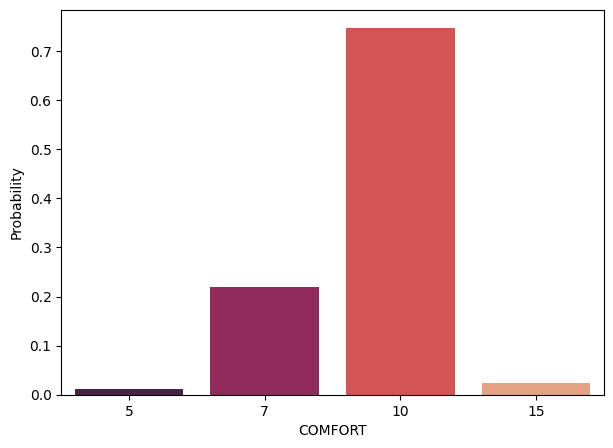

In [13]:
fig, ax = plt.subplots(figsize=(7, 5), sharex=True)
ax = seaborn.barplot(x=[5,7,10,15], y=np.array(updates[0]), palette="rocket")
ax.set_ylabel('Probability')
ax.set_xlabel('COMFORT')